<a href="https://colab.research.google.com/github/Vengadore/Notebooks/blob/master/Training_optic_Discs_in_Efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetic Retinopathy Detection

Kaggle has a large competition of Diabetic Retinopathy detection which can be found here:
https://www.kaggle.com/c/diabetic-retinopathy-detection/

Their dataset consists in 35126 images labeled from 0 to 4 according to the degree of Retinopathy.
An analysis of the data is provided in this notebook.

In [1]:
!rm -rf sample_data
!nvidia-smi

Thu Nov 19 17:04:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install dependencies

In [2]:
from IPython.display import clear_output

!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install efficientnet_pytorch
clear_output(wait=False)

## Load data from local drive


In [3]:
!wget -O File.zip "https://correoipn-my.sharepoint.com/:u:/g/personal/ccarrillog1400_alumno_ipn_mx/ETdcB8GscyBAkhUFvNMzpoUBLLgg7ej9Q3t4rK_bR8ngSA?download=1"
!unzip File.zip
!rm File.zip
clear_output(wait=False)
print("Data Downloaded")

Data Downloaded


In [1]:
!rm checkpoint*

In [2]:
import pandas as pd
import os

Bad =  pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Neovessels",File) for File in os.listdir("./OpticDiscs/Neovessels") if ".jpeg" in File]})
Good = pd.DataFrame({"imageFilename":[os.path.join("./OpticDiscs/Good images",File) for File in os.listdir("./OpticDiscs/Good images") if ".jpeg" in File]}).sample(len(Bad),random_state = 42)

data = pd.concat((Good,Bad),axis = 0)
data.head()
data['class'] = data['imageFilename'].apply(lambda x : 1 if "Good" in x else 0)
data = data.reset_index()
data = data[['imageFilename','class']]
data.head()

,imageFilename,class
0,./OpticDiscs/Good images/22445_right.jpeg,1
1,./OpticDiscs/Good images/15510_right.jpeg,1
2,./OpticDiscs/Good images/5692_right.jpeg,1
3,./OpticDiscs/Good images/21578_right.jpeg,1
4,./OpticDiscs/Good images/35584_right.jpeg,1


In [3]:
len(data)

374

#### Split data

In [4]:
from sklearn.model_selection import train_test_split

#Split data
X_train, X_test, y_train, y_test = train_test_split(data['imageFilename'], data['class'], test_size=0.30, random_state=65)

In [5]:
y_train.value_counts()

0    139
1    122
Name: class, dtype: int64

In [6]:
test_data = pd.DataFrame({'image':X_test,'class':y_test})
test_data['image'] = test_data['image'].apply(lambda x : x.split('/')[-1])
test_data.head()

,image,class
278,6719_left.jpeg,0
366,43050_left.jpeg,0
287,21205_left.jpeg,0
202,35955_right.jpeg,0
146,5750_right.jpeg,1


In [7]:
test_data.to_csv('test_data.csv',index=False)

## Definition of the model

In [8]:
from efficientnet_pytorch import EfficientNet
import torch
network_name = 'efficientnet-b7'
model = EfficientNet.from_pretrained(network_name)

Loaded pretrained weights for efficientnet-b7


In [9]:
model._fc

Linear(in_features=2560, out_features=1000, bias=True)

In [10]:
## Change efficientnet final layer
model._fc = torch.nn.Linear(in_features=2560,out_features=2,bias = True)

In [11]:
from torchvision.transforms import Resize,ToTensor,Compose,Normalize
from torchvision.transforms import RandomHorizontalFlip,RandomVerticalFlip,RandomRotation,ColorJitter
from PIL import Image

transforms = Compose([RandomHorizontalFlip(),RandomVerticalFlip(),RandomRotation(180),ColorJitter(0.5,0.5,0.5)]) # Transformations for the training images

composed = Compose([Resize(600), # Resize to a fit size for efficientnet
                    ToTensor(),  # Convert into sensor
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # Normalize image

### Training parameters

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device);
seed = 17
torch.manual_seed(seed)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [13]:
try:
    model = torch.load('./checkpoint_b0_11.ph', map_location=device)
except:
    print("No Checkpoint loaded")

No Checkpoint loaded


In [14]:
classes = {0:[0,0,0,0,1],
           1:[0,0,0,1,0],
           2:[0,0,1,0,0],
           3:[0,1,0,0,0],
           4:[1,0,0,0,0]}

In [15]:
from tqdm import tqdm
import random
random.seed(seed)

epochs = 100
batch_size = 1  # I will use batch size of 1 to keep the ratio of each image

TRAINING_acc = []
VALIDATION_acc = []
BEST_val_acc = 0.0

for epoch in range(epochs):
    
    indexes = [idx for idx in range(len(X_train))]
    pbar = tqdm( range(len(X_train)//batch_size),ncols = 100)
    running_loss = 0.0
    running_acc = 0.0
    t = 0

    for step in pbar:
        # Load data
        idx = random.sample(indexes,batch_size)
        X = X_train.iloc[idx]
        y = y_train.iloc[idx]

        # Remove indexes
        [indexes.remove(i) for i in idx]

        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = transforms(image)
            P = composed(P).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        t += batch_size

        _, preds = torch.max(outputs, 1)
        running_acc += torch.sum(preds == y_true).cpu().detach().numpy()
        acc = torch.sum(preds == y_true).cpu().detach().numpy()/batch_size;
        pbar.set_description("Epoch: {} Accuracy: {:0.5f} Loss: {:0.5f} ".format(epoch+1,running_acc/t,loss.item()))
    #Validation
    TRAINING_acc.append(running_acc/t)
    val_acc = 0.0
    val_loss = 0.0
    t = 0
    for point in range(len(X_test)//batch_size):
        with torch.no_grad():

            X = X_test.iloc[point*batch_size:(point+1)*batch_size]
            y = y_test.iloc[point*batch_size:(point+1)*batch_size]


            # Load images
            try:
                images = [Image.open(File) for File in X]
            except:
                continue
            # Load y_true
            y_true = torch.LongTensor([c for c in y]).to(device)
            
            # Convert images to tensor
            x_batch = torch.FloatTensor().to(device)
            for image in images:
                P = composed(image).unsqueeze(0).to(device)
                x_batch = torch.cat((x_batch,P))

            
            outputs = model(x_batch)
            loss = criterion(outputs, y_true)
            val_loss += loss.item()
            t += batch_size
            _, preds = torch.max(outputs, 1)
            val_acc += torch.sum(preds == y_true).cpu().detach().numpy()
    VALIDATION_acc.append(val_acc/t)
    print("Validation -- Accuracy: {:0.5f} Loss: {:0.5f} \n".format(val_acc/t,loss.item()))
    if val_acc/t > BEST_val_acc:
        try:
            torch.save(model,"/content/checkpoint_{}_{}_{:0.5f}.ph".format(network_name,epoch+1,val_acc/t))
            BEST_val_acc = val_acc/t
        except:
            continue

Epoch: 1 Accuracy: 0.62452 Loss: 0.39216 : 100%|██████████████████| 261/261 [02:07<00:00,  2.05it/s]


Validation -- Accuracy: 0.83186 Loss: 0.44575 



Epoch: 2 Accuracy: 0.80077 Loss: 0.39246 : 100%|██████████████████| 261/261 [02:07<00:00,  2.05it/s]


Validation -- Accuracy: 0.84071 Loss: 0.14327 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.81416 Loss: 0.19140 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84071 Loss: 0.17923 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.76106 Loss: 0.72193 



Epoch: 6 Accuracy: 0.90421 Loss: 0.03616 : 100%|██████████████████| 261/261 [02:08<00:00,  2.04it/s]


Validation -- Accuracy: 0.84956 Loss: 0.05432 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.76106 Loss: 0.12637 



Epoch: 8 Accuracy: 0.89272 Loss: 0.00904 : 100%|██████████████████| 261/261 [02:07<00:00,  2.04it/s]


Validation -- Accuracy: 0.86726 Loss: 0.14815 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84071 Loss: 0.00490 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84956 Loss: 0.03241 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.83186 Loss: 0.27583 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.62832 Loss: 0.81268 



Epoch: 13 Accuracy: 0.91954 Loss: 0.03779 : 100%|█████████████████| 261/261 [02:07<00:00,  2.04it/s]


Validation -- Accuracy: 0.89381 Loss: 0.00819 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.00170 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.89381 Loss: 0.01180 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.01809 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.82301 Loss: 0.28278 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.66372 Loss: 1.15220 



Epoch: 19 Accuracy: 0.96169 Loss: 1.26262 : 100%|█████████████████| 261/261 [02:07<00:00,  2.05it/s]


Validation -- Accuracy: 0.90265 Loss: 0.04222 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.84956 Loss: 0.26301 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.87611 Loss: 0.03690 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.87611 Loss: 0.04146 



Epoch: 23 Accuracy: 0.95402 Loss: 0.00445 : 100%|█████████████████| 261/261 [02:07<00:00,  2.04it/s]


Validation -- Accuracy: 0.92920 Loss: 0.00420 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.04899 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.01002 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.00246 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.00229 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.89381 Loss: 0.21061 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.86726 Loss: 0.00415 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.87611 Loss: 0.01047 



Epoch: 31 Accuracy: 0.98467 Loss: 0.02837 : 100%|█████████████████| 261/261 [02:07<00:00,  2.04it/s]


Validation -- Accuracy: 0.94690 Loss: 0.00223 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.82301 Loss: 0.75077 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.00736 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.91150 Loss: 0.00014 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.89381 Loss: 0.10026 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.89381 Loss: 0.00187 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.87611 Loss: 0.00006 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.89381 Loss: 0.00243 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.00088 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.89381 Loss: 0.00008 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.00241 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.91150 Loss: 0.00651 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.90265 Loss: 0.00128 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.00009 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.01370 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.89381 Loss: 0.01753 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.91150 Loss: 0.15880 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.90265 Loss: 0.00297 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.00878 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.15373 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.90265 Loss: 0.00156 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.00277 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.88496 Loss: 0.00059 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92920 Loss: 0.03204 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.00332 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.86726 Loss: 0.01153 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93805 Loss: 0.00229 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92920 Loss: 0.00325 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93805 Loss: 0.00145 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.93805 Loss: 0.00047 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.91150 Loss: 0.00030 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.00021 



  0%|                                                                       | 0/261 [00:00<?, ?it/s]

Validation -- Accuracy: 0.92035 Loss: 0.00003 



Epoch: 64 Accuracy: 1.00000 Loss: 0.00003 :   7%|█▎                | 19/261 [00:09<01:55,  2.09it/s]

KeyboardInterrupt: ignored

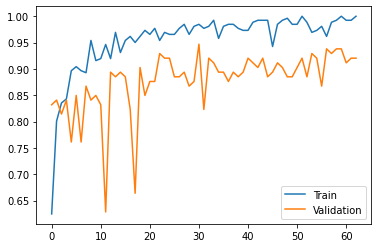

In [16]:
history = pd.DataFrame({"Train":TRAINING_acc,"Validation":VALIDATION_acc})
history.plot()

In [21]:
!ls

checkpoint_efficientnet-b4_10_0.76991.ph
checkpoint_efficientnet-b4_1_0.49558.ph
checkpoint_efficientnet-b4_14_0.79646.ph
checkpoint_efficientnet-b4_15_0.80531.ph
checkpoint_efficientnet-b4_5_0.51327.ph
checkpoint_efficientnet-b4_6_0.60177.ph
checkpoint_efficientnet-b4_7_0.61947.ph
checkpoint_efficientnet-b4_8_0.69912.ph
checkpoint_efficientnet-b4_9_0.73451.ph
OpticDiscs
test_data.csv


In [ ]:
torch.save(model,"checkpoint.ph")

In [ ]:
for c in y:
  print(c)

0


## Evaluation

In [ ]:
model = torch.load('checkpoint_efficientnet-b7_33_0.94690.ph')

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

In [ ]:
predicted = []
true_values = []
for point in range(len(X_test)//batch_size):
    with torch.no_grad():

        X = X_test.iloc[point*batch_size:(point+1)*batch_size]
        y = y_test.iloc[point*batch_size:(point+1)*batch_size]

        true_values.append(y.values)
        # Load images
        try:
            images = [Image.open(File) for File in X]
        except:
            continue
        # Load y_true
        y_true = torch.LongTensor([c for c in y]).to(device)
        
        # Convert images to tensor
        x_batch = torch.FloatTensor().to(device)
        for image in images:
            P = composed(image).unsqueeze(0).to(device)
            x_batch = torch.cat((x_batch,P))

        
        outputs = model(x_batch)
        loss = criterion(outputs, y_true)
        
        _, preds = torch.max(outputs, 1)
        predicted.append(preds)

In [ ]:
true_values = np.array(true_values).reshape(-1)
dummy = torch.FloatTensor().to(device)
for tensor in predicted:
    dummy = torch.cat((dummy,tensor))
predicted = dummy.view(-1).cpu().numpy()

In [ ]:
confusion_matrix(true_values, predicted)

array([[46,  2],
       [ 7, 58]])